In [145]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

tf.keras.backend.set_floatx("float64")  # we want to carry out GP calculations in 64 bit
tf.get_logger().setLevel("INFO")

In [146]:
class Config:
    num_inducing=50
    inner_layer_qsqrt_factor=1e-5
    likelihood_noise_variance=1e-2
    whiten=True

    num_layers=20


    # Training
    batch_size=24
    learning_rate=0.01
    epochs = 30
    

In [147]:
from sklearn.preprocessing import StandardScaler

In [148]:
def return_data(fold,month,with_scaling, station_id = None):
  train_input = pd.read_csv('data/beijing-18/time_feature/'+'/fold'+str(fold)+'/train_data_'+month+'_nsgp.csv.gz')
  test_input = pd.read_csv('data/beijing-18/time_feature'+'/fold'+str(fold)+'/test_data_'+month+'_nsgp.csv.gz')
  if station_id != None:
    test_input = test_input[test_input['station_id'] == station_id]
  #     test_input = test_input[test_input['station_id' == ]]
  test_output = np.array(test_input['PM25_Concentration'])
  train_output = np.array(train_input['PM25_Concentration'])
  train_input= train_input.drop(['station_id','PM25_Concentration','time','filled'],axis=1)
  try:
    test_input= test_input.drop(['PM25_Concentration','station_id','time','filled'],axis=1)
  except:
    test_input= test_input.drop(['station_id','time','filled'],axis=1)
  #     test_output= test_output.drop(['time'],axis=1)
  if with_scaling:
    scaler = StandardScaler().fit(train_input)
    train_input = pd.DataFrame(scaler.transform(train_input),columns=list(train_input.columns))
    test_input = pd.DataFrame(scaler.transform(test_input),columns=list(test_input.columns))
  return train_input,train_output,test_input,test_output


In [149]:
# np.random.seed(42)
# X=np.random.rand(100,2)
# # noise=np.random.normal(0,1,100)
# Y=-8*X[:,0] - 6*X[:,1] + 3
# X=X
# # print(X)
# # X=X.reshape(-1,1)
# Y=Y.reshape(-1,1)
# print(X.shape)
# print


In [150]:
# plt.plot(train_input.iloc[:,1], train_output, "kx")
# plt.xlabel("X")
# plt.ylabel("Y")


In [151]:
# !pip install gpflux

In [152]:
# os.environ["CUDA_DEVICE_ORDER"]= "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]= '0'

In [153]:
import gpflux

from gpflux.architectures import build_constant_input_dim_deep_gp
from gpflux.models import DeepGP

for fold in [0]:
    train_input,train_output,test_input,test_output = return_data(fold=fold,month='mar',with_scaling=True)
    train_output = train_output.reshape(-1,1)
    print(train_input.shape,train_output.shape)
   
    print("Fold: ",fold)
    print("Data received")

    config = gpflux.architectures.Config(
        num_inducing=Config.num_inducing, inner_layer_qsqrt_factor=Config.inner_layer_qsqrt_factor, likelihood_noise_variance=Config.likelihood_noise_variance, whiten=True
    )
    deep_gp: DeepGP = build_constant_input_dim_deep_gp(train_input, num_layers=Config.num_layers, config=config)

    training_model: tf.keras.Model = deep_gp.as_training_model()

    # Following the Keras procedure we need to compile and pass a optimizer,
    # before fitting the model to data
    training_model.compile(optimizer=tf.optimizers.Adam(learning_rate=Config.learning_rate))

    callbacks = [
        # Create callback that reduces the learning rate every time the ELBO plateaus
        tf.keras.callbacks.ReduceLROnPlateau("loss", factor=0.95, patience=3, min_lr=1e-6, verbose=0),
        # Create a callback that writes logs (e.g., hyperparameters, KLs, etc.) to TensorBoard
        gpflux.callbacks.TensorBoard(),
        # Create a callback that saves the model's weights
        tf.keras.callbacks.ModelCheckpoint(filepath="ckpts/", save_weights_only=True, verbose=0),
    ]

    history = training_model.fit(
        {"inputs": train_input, "targets": train_output},
        batch_size=Config.batch_size,
        epochs=Config.epochs,
        callbacks=callbacks,
        verbose=1,
    )

(14880, 8) (14880, 1)
Fold:  0
Data received


2022-03-26 16:39:31.484568: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-03-26 16:39:31.484627: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-03-26 16:39:31.485788: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-03-26 16:39:31.485916: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed


Epoch 1/30
  2/620 [..............................] - ETA: 7:06 - loss: 608246.7825 - gp_0_prior_kl: 0.2032 - gp_1_prior_kl: 0.2032 - gp_2_prior_kl: 0.2032 - gp_3_prior_kl: 0.2032 - gp_4_prior_kl: 0.2032 - gp_5_prior_kl: 0.2032 - gp_6_prior_kl: 0.2032 - gp_7_prior_kl: 0.2032 - gp_8_prior_kl: 0.2032 - gp_9_prior_kl: 0.2032 - gp_10_prior_kl: 0.2032 - gp_11_prior_kl: 0.2032 - gp_12_prior_kl: 0.2032 - gp_13_prior_kl: 0.2032 - gp_14_prior_kl: 0.2032 - gp_15_prior_kl: 0.2032 - gp_16_prior_kl: 0.2032 - gp_17_prior_kl: 0.2032 - gp_18_prior_kl: 0.2032 - gp_19_prior_kl: 2.3101e-06   

2022-03-26 16:39:50.921906: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-03-26 16:39:50.921984: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-03-26 16:39:52.029924: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-03-26 16:39:52.036036: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed
2022-03-26 16:39:52.153775: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-03-26 16:39:52.174264: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-03-26 16:39:52.214666: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/train/plugins/profile/2022_03_26_16_39_52


  6/620 [..............................] - ETA: 4:19 - loss: 599128.4215 - gp_0_prior_kl: 0.1263 - gp_1_prior_kl: 0.1263 - gp_2_prior_kl: 0.1263 - gp_3_prior_kl: 0.1263 - gp_4_prior_kl: 0.1263 - gp_5_prior_kl: 0.1263 - gp_6_prior_kl: 0.1263 - gp_7_prior_kl: 0.1263 - gp_8_prior_kl: 0.1263 - gp_9_prior_kl: 0.1263 - gp_10_prior_kl: 0.1263 - gp_11_prior_kl: 0.1263 - gp_12_prior_kl: 0.1263 - gp_13_prior_kl: 0.1263 - gp_14_prior_kl: 0.1263 - gp_15_prior_kl: 0.1263 - gp_16_prior_kl: 0.1263 - gp_17_prior_kl: 0.1263 - gp_18_prior_kl: 0.1263 - gp_19_prior_kl: 2.1538e-05 

2022-03-26 16:39:52.233937: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_03_26_16_39_52/ramanujan.trace.json.gz
2022-03-26 16:39:52.269105: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/train/plugins/profile/2022_03_26_16_39_52
2022-03-26 16:39:52.269363: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for memory_profile.json.gz to logs/train/plugins/profile/2022_03_26_16_39_52/ramanujan.memory_profile.json.gz
2022-03-26 16:39:52.272288: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: logs/train/plugins/profile/2022_03_26_16_39_52Dumped tool data for xplane.pb to logs/train/plugins/profile/2022_03_26_16_39_52/ramanujan.xplane.pb
Dumped tool data for overview_page.pb to logs/train/plugins/profile/2022_03_26_16_39_52/ramanujan.overview_page.pb
Dumped tool data for input_pipeline.pb to logs/t

620/620 [==============================] - 35s 27ms/step - loss: 143318.9745 - gp_0_prior_kl: 0.1521 - gp_1_prior_kl: 0.1571 - gp_2_prior_kl: 0.1515 - gp_3_prior_kl: 0.1550 - gp_4_prior_kl: 0.1529 - gp_5_prior_kl: 0.1540 - gp_6_prior_kl: 0.1542 - gp_7_prior_kl: 0.1539 - gp_8_prior_kl: 0.1584 - gp_9_prior_kl: 0.1540 - gp_10_prior_kl: 0.1537 - gp_11_prior_kl: 0.1527 - gp_12_prior_kl: 0.1537 - gp_13_prior_kl: 0.1539 - gp_14_prior_kl: 0.1520 - gp_15_prior_kl: 0.1527 - gp_16_prior_kl: 0.1533 - gp_17_prior_kl: 0.1527 - gp_18_prior_kl: 0.1556 - gp_19_prior_kl: 0.0179
Epoch 2/30
620/620 [==============================] - 15s 24ms/step - loss: 16097.1980 - gp_0_prior_kl: 0.2124 - gp_1_prior_kl: 0.2143 - gp_2_prior_kl: 0.2109 - gp_3_prior_kl: 0.2191 - gp_4_prior_kl: 0.2117 - gp_5_prior_kl: 0.2150 - gp_6_prior_kl: 0.2177 - gp_7_prior_kl: 0.2143 - gp_8_prior_kl: 0.2207 - gp_9_prior_kl: 0.2124 - gp_10_prior_kl: 0.2111 - gp_11_prior_kl: 0.2106 - gp_12_prior_kl: 0.2103 - gp_13_prior_kl: 0.2169 - gp_1

In [154]:
# # From the `DeepGP` model we instantiate a training model which is a `tf.keras.Model`
# training_model: tf.keras.Model = deep_gp.as_training_model()

# # Following the Keras procedure we need to compile and pass a optimizer,
# # before fitting the model to data
# training_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01))

# callbacks = [
#     # Create callback that reduces the learning rate every time the ELBO plateaus
#     tf.keras.callbacks.ReduceLROnPlateau("loss", factor=0.95, patience=3, min_lr=1e-6, verbose=0),
#     # Create a callback that writes logs (e.g., hyperparameters, KLs, etc.) to TensorBoard
#     gpflux.callbacks.TensorBoard(),
#     # Create a callback that saves the model's weights
#     tf.keras.callbacks.ModelCheckpoint(filepath="ckpts/", save_weights_only=True, verbose=0),
# ]

# history = training_model.fit(
#     {"inputs": train_input, "targets": train_output},
#     batch_size=12,
#     epochs=50,
#     callbacks=callbacks,
#     verbose=0,
# )

Text(0, 0.5, 'Learning rate')

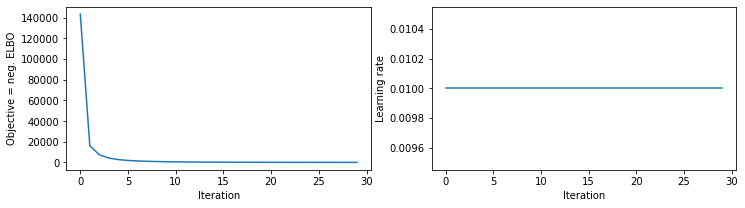

In [155]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
ax1.plot(history.history["loss"])
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Objective = neg. ELBO")

ax2.plot(history.history["lr"])
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Learning rate")

In [156]:
# def plot(model, X, Y, ax=None):
#     if ax is None:
#         fig, ax = plt.subplots()

#     x_margin = 1.0
#     N_test = 100
#     X_test = np.linspace(X.min() - x_margin, X.max() + x_margin, N_test).reshape(-1, 1)
#     out = model(X_test)

#     mu = out.f_mean.numpy().squeeze()
#     var = out.f_var.numpy().squeeze()
#     X_test = X_test.squeeze()
#     lower = mu - 2 * np.sqrt(var)
#     upper = mu + 2 * np.sqrt(var)

#     ax.set_ylim(Y.min() - 0.5, Y.max() + 0.5)
#     ax.plot(X.iloc[:,0], Y, "kx", alpha=0.5)
#     ax.plot(X_test, mu, "C1")

#     ax.fill_between(X_test, lower, upper, color="C1", alpha=0.3)


prediction_model = deep_gp.as_prediction_model()
print(prediction_model)
# plot(prediction_model,test_input,test_output)

In [157]:
# prediction_model = deep_gp.as_prediction_model()
from sklearn.metrics import mean_squared_error
Test_pred = prediction_model.predict(np.array(test_input))
err = mean_squared_error(Test_pred, test_output, squared=False)


In [158]:
print(err)

37.90253438840399
